# 利用BOW, Naive Bayes, 建立文檔分類模型，並儲存模型 

包含下列步驟 (使用 scikit-learn)
> 1. 建立 詞袋(BOW) by CountVectorizer 

> 2. 建立 ML model

> 3. 利用 GridSearchCV 尋找最佳參數

> 4. 嘗試使用 TfidfVectorizer，比較效果

> 5. 顯示模型結果: Confusion Matrix

> 6. 顯示模型結果: Classification Report

#### 效果展示

1. 訓練資料樣式: <br>
    Label:  客服╱門市╱業務╱貿易類 <br>
    Content: 介紹 銷售 商品 顧客 接待 服務 電話 諮詢 調貨 包裝 退換貨 商品 進貨 入庫 銷售 管理 庫存 管理 商品 包裝 陳列 促銷品 換檔 維持 店櫃 週遭 整潔 提升 業績 淑女 服飾 銷售 服務 門市 店員 專櫃 Windows Outlook
<br><br>
2. 訓練 MultinomialNB model (Naive Bayes多分類模型) ， GridSearchCV 得到的最佳參數 Alpha = 0.1
<br><br>
3. 使用 CountVectorizer 的 accuracy : 0.8353739939733761 <br>
   使用 TfidfVectorizer 的 accuracy : 0.8451767936834879 <br>
   -> TfidfVectorizer 效果比較好一點，大致上差不多

## 1. read Job data from MongoDB (data after Jieba)

In [21]:
import pymongo
from secrets import HOST

In [22]:
def mongo_select_jobs(): 
    
    global mycol
    client = pymongo.MongoClient(HOST) 

    db = client['jieba_clean'] 
    mycol = db['job_clean'] 

    data = mycol.find({},{'_id':0}) # get data from mongoDB
    
    output = [i for i in data]
    
    return output

In [23]:
job_data = mongo_select_jobs()

In [24]:
print('所有資料數量: ', len(job_data))

所有資料數量:  131083


In [25]:
# 將數據儲存成模型訓練用 list
lst_job_cat = [i['jobCat_main'] for i in job_data]
lst_jobs = [' '.join(i['jobDescription_concate_jieba'][0]) for i in job_data]

顯示2筆訓練資料樣式

In [26]:
for i, j in list(zip(lst_job_cat, lst_jobs))[0:2]:
    print('Label: ', i)
    print(j)
    print('='*20)

Label:  客服╱門市╱業務╱貿易類
介紹 銷售 商品 顧客 接待 服務 電話 諮詢 調貨 包裝 退換貨 商品 進貨 入庫 銷售 管理 庫存 管理 商品 包裝 陳列 促銷品 換檔 維持 店櫃 週遭 整潔 提升 業績 淑女 服飾 銷售 服務 門市 店員 專櫃 Windows Outlook
Label:  客服╱門市╱業務╱貿易類
傢俱 連鎖 事業 系統 傢俱 設計 制度 多元 發展 事業 業務 設計 銷售 系統 傢俱 業主 系統 介紹 工地丈量 繪圖 監工 業主 服務 走向 專業 發展 設計 交通工具 業務人員 客戶 資料 維護 業務 通路開發 業績 分配 Excel Word


## 4. 建立Bag of Words (BOW)，將文本轉換為稀疏矩陣

使用CountVectorizer

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
import pickle

In [28]:
# 參數min_df=5表示詞必須要在至少5個文檔中出現過，否則就不考慮。
# 限制特徵值上限10000來降低維度
vect = CountVectorizer(min_df=10, stop_words="english", max_features=10000).fit(lst_jobs)
transform_content = vect.transform(lst_jobs) 

In [29]:
# 儲存 CountVectorizer 模型 
# pickle.dump(vectorizer, open("model/vectorizer.pickel", "wb"))

In [30]:
# 查看稀疏矩陣的特徵內容
feature_names = vect.get_feature_names()

print("length of features:\n{}".format(len(feature_names))) 
print("Show 100 features:\n{}".format(feature_names[5000:5100])) 

length of features:
10000
Show 100 features:
['引擎', '引擎分析儀', '引擎室', '引流', '引發', '引薦', '引進', '弱勢', '弱勢者', '張貼', '強制', '強項', '彌月', '彙報', '彙整', '彙編', '彙總', '形態', '形成', '形象', '彩券', '彩妝', '彩繪', '彩繪師', '彩色', '影像', '影像處理', '影印', '影印本', '影城', '影本', '影片', '影視', '影音', '待人接物', '待命', '待客', '待客之道', '待辦', '待過', '律師', '後勤', '後台', '後場', '後將', '後期', '後端', '後線人員', '後製', '後製作業', '後須', '得心應手', '得獎', '得體', '從業人員', '復健', '復健科', '復健醫學', '循環', '微信', '微博', '微控制器', '微整', '微機電', '微波', '微波爐', '微生物', '微調', '微軟', '徵人', '徵信', '徵信社', '徵審', '徵才', '徵授信', '徵收', '徵聘', '徵象', '徵選', '德南', '德安飯店', '德文', '心理', '心理學', '心理師', '心臟', '心血管', '心電圖', '忍受', '志工', '志業', '快取', '快餐', '思考', '思路', '思辨', '急件', '急性', '急救箱', '急用']


## 5. 建立ML model 

#### a. label encoding to job category

In [31]:
from sklearn import preprocessing

In [43]:
X = transform_content.toarray() 

print('X的總樣本數量: ', len(X))
print('X的樣本的特徵數量: ', len(X[0]))

X的總樣本數量:  131083
X的樣本的特徵數量:  10000


In [44]:
le = preprocessing.LabelEncoder()
le.fit(lst_job_cat)
y = le.transform(lst_job_cat)

print('原始的資料類別數量: ', len(list(le.classes_)))
print('原始的資料標籤: ', list(le.classes_))
print('轉換後的前10筆資料: ', y[0:10])

原始的資料類別數量:  18
原始的資料標籤:  ['傳播藝術╱設計類', '其他職類', '學術╱教育╱輔導類', '客服╱門市╱業務╱貿易類', '操作╱技術╱維修類', '文字╱傳媒工作類', '營建╱製圖類', '生產製造╱品管╱環衛類', '研發相關類', '經營╱人資類', '行政╱總務╱法務類', '行銷╱企劃╱專案管理類', '財會╱金融專業類', '資材╱物流╱運輸類', '資訊軟體系統類', '軍警消╱保全類', '醫療╱保健服務類', '餐飲╱旅遊 ╱美容美髮類']
轉換後的前10筆資料:  [ 3  3 12 12  4 17 12  3 12  7]


#### b. train test split

In [34]:
from sklearn.model_selection import train_test_split

In [46]:
# Splitting the dataset into the Training set and Test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### c. build MultinomialNB model

In [47]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from joblib import dump, load

# 参数 alpha，用于控制模型复杂度。alpha 越大，平滑化越强，模型复杂度就越低。

model = MultinomialNB(alpha = 0.1) 
model.fit(X_train, y_train) 

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [48]:
# 儲存 MultinomialNB 模型 
# dump(model, 'model/MultinomialNB.joblib') 

In [55]:
y_pred = model.predict(X_test)
print('get accuracy score: ')
accuracy_score(y_test, y_pred)

get accuracy score: 


0.8383873059465232

#### d. use GridSearchCV to find best parameter

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline 


pipe = make_pipeline(MultinomialNB()) 
param_grid = {"multinomialnb__alpha": [0.001, 0.01, 0.1, 1] } 
 
grid = GridSearchCV(pipe, param_grid, cv=5) 
grid.fit(X_train, y_train) 
print("Best cross-validation score: {:.2f}".format(grid.best_score_)) 
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.84
Best parameters:
{'multinomialnb__alpha': 0.01}


## 6.嘗試使用 TfidfVectorizer，比較效果

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer 

In [50]:
vect_tfidf = TfidfVectorizer(min_df=10, stop_words="english", max_features=10000).fit(lst_jobs)

transform_content_tfidf = vect_tfidf.transform(lst_jobs) 
X_tfidf = transform_content_tfidf.toarray() 

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=0)

model = MultinomialNB(alpha = 0.1) 
model.fit(X_train_tfidf, y_train) 

y_pred = model.predict(X_test_tfidf)
print('get accuracy score: ')
accuracy_score(y_test, y_pred)

get accuracy score: 


0.8451767936834879

## 7. 顯示模型結果: Confusion Matrix

In [51]:
from sklearn.metrics import plot_confusion_matrix

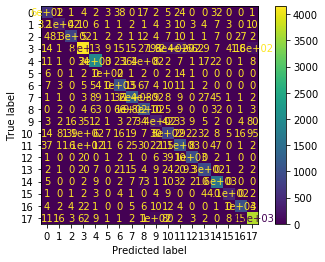

In [52]:
plot_confusion_matrix(model, X_test, y_test)

## 8. 顯示模型結果: Classification Report

In [53]:
from sklearn.metrics import classification_report

In [56]:
print(classification_report(y_test, y_pred, labels=[i for i in range(0, 18)]))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       731
           1       0.89      0.81      0.85       380
           2       0.91      0.91      0.91       920
           3       0.90      0.82      0.86      5066
           4       0.88      0.86      0.87      2265
           5       0.73      0.78      0.75       129
           6       0.81      0.85      0.83      1208
           7       0.80      0.76      0.78      1566
           8       0.66      0.77      0.71      1274
           9       0.51      0.55      0.53       613
          10       0.63      0.63      0.63      1260
          11       0.70      0.77      0.73      1383
          12       0.89      0.92      0.91      1078
          13       0.88      0.88      0.88      1064
          14       0.88      0.92      0.90      1737
          15       0.95      0.93      0.94       443
          16       0.92      0.93      0.93      1088
          17       0.91    

In [60]:
print('原始的資料標籤: ' )
for i ,j in enumerate(list(le.classes_)):
    print(i,j)

原始的資料標籤: 
0 傳播藝術╱設計類
1 其他職類
2 學術╱教育╱輔導類
3 客服╱門市╱業務╱貿易類
4 操作╱技術╱維修類
5 文字╱傳媒工作類
6 營建╱製圖類
7 生產製造╱品管╱環衛類
8 研發相關類
9 經營╱人資類
10 行政╱總務╱法務類
11 行銷╱企劃╱專案管理類
12 財會╱金融專業類
13 資材╱物流╱運輸類
14 資訊軟體系統類
15 軍警消╱保全類
16 醫療╱保健服務類
17 餐飲╱旅遊 ╱美容美髮類
